In [1]:
import numpy as np
from scipy.linalg import block_diag
import random
from math import pi, sqrt
import sys
import os.path
import matplotlib.pyplot as plt
import time

In [4]:
def hopp_vec(Mx,My,vec,px,py):
    # generates hoping matrix on square lattice
    # vec= hopping vector
    # py=1 PBC along y otherwise OBC
    # px=1 PBC along x otherwise OBC
    
    hopin=np.zeros(shape=(Mx*My,Mx*My),dtype=complex)
    for i_y in range(My):
        for i_x in range(Mx):
            i_px=i_x+vec[0]
            i_py=i_y+vec[1]
            if ((i_px>=Mx or i_px<0) and i_py< My and i_py>=0):
                if i_px>=Mx :
                    hx=px
                else:
                    hx=px.conjugate()
                i_px=i_px%Mx
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=hx
            elif ((i_py>=My or i_py<0) and i_px< Mx and i_px>=0):
                if i_py>=My :
                    hy=py
                else:
                    hy=py.conjugate()
                    
                i_py=i_py%My
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=hy
                    
            elif (i_px>=Mx or i_px<0) and (i_py>=My or i_py<0):
                if i_px>=Mx:
                    hx=px
                else:
                    hx=px.conjugate()
    
                if i_py>=My:
                    hy=py
                else:
                    hy=py.conjugate()
                i_px=i_px%Mx
                i_py=i_py%My
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=hx*hy
                
            elif i_px>=0 and i_px<Mx and i_py>=0 and i_py<My :
                hopin[i_px+i_py*Mx,i_x+i_y*Mx]=1
                    
    return hopin


# generates single particle states
def wf_gen(Lx,Ly,px,py,N_pt,t):
    H1_hop=hopp_vec(Lx,Ly,[0,1],px,py)+hopp_vec(Lx,Ly,[1,0],px,py)
    H1=-t*(H1_hop+H1_hop.T)/2
    energies, evecs= np.linalg.eigh(H1)
    return evecs[:,:N_pt]

In [5]:
def exact_renyi_calc(r,GA,epsilon=1e-9):
    chi0, _ =np.linalg.eigh(GA)
    chi1=chi0[np.nonzero(np.abs(chi0)>epsilon)]
    chi2=chi1[np.nonzero(np.abs(chi1-1)>epsilon)]
#     return -np.sum((1-chi2)*np.log(1-chi2)+chi2*np.log(chi2))
    return np.sum(np.log((1-chi2)**r+chi2**r))/(1-r)


def exact_log_neg_calc(Na,Nb,GA,epsilon=1e-9):
    """computes log negativity of 1d free fermions"""
    Nt=Na+Nb

    Gm=np.eye(Nt)-2*GA
    Sp=np.array([[0,1],[0,0]])
    Gm_1=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,-1j*Gm[:Na,Na:])+np.kron(Sp.T,-1j*Gm[Na:,:Na])
    Gm_2=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,1j*Gm[:Na,Na:])+np.kron(Sp.T,1j*Gm[Na:,:Na])    
    Gx=np.dot(np.eye(Nt)-Gm_2,np.dot(np.linalg.inv(np.eye(Nt)+np.dot(Gm_1,Gm_2)),np.eye(Nt)-Gm_1))/2
    Gxh=(Gx+np.transpose(Gx).conj())/2

    chi0 =np.linalg.eigvalsh(Gxh)
    i0=np.nonzero(np.abs(chi0)>epsilon)[0]
    chi1=chi0[i0]
    i1=np.nonzero(np.abs(chi1-1)>epsilon)[0]
    nu=chi1[i1]
    eA=np.sum(np.log(nu**0.5+(1-nu)**0.5))
    
    chi,VR=np.linalg.eigh(GA)
    sA=np.sum(np.log(chi**2+(1-chi)**2))/2    

    return eA+sA

def exact_Renyi_neg_calc2(r,Na,Nb,GA,epsilon=1e-9):
    """computes log negativity of 1d free fermions only works for even r"""
    Nt=Na+Nb

    Gm=np.eye(Nt)-2*GA
    Sp=np.array([[0,1],[0,0]])
    Gm_1=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,-1j*Gm[:Na,Na:])+np.kron(Sp.T,-1j*Gm[Na:,:Na])
    Gm_2=block_diag(-Gm[:Na,:Na],Gm[Na:,Na:])\
        +np.kron(Sp,1j*Gm[:Na,Na:])+np.kron(Sp.T,1j*Gm[Na:,:Na])    
    Gx=np.dot(np.eye(Nt)-Gm_2,np.dot(np.linalg.inv(np.eye(Nt)+np.dot(Gm_1,Gm_2)),np.eye(Nt)-Gm_1))/2
    Gxh=(Gx+np.transpose(Gx).conj())/2

    chi0 =np.linalg.eigvalsh(Gxh)
    i0=np.nonzero(np.abs(chi0)>epsilon)[0]
    chi1=chi0[i0]
    i1=np.nonzero(np.abs(chi1-1)>epsilon)[0]
    nu=chi1[i1]
    eA=np.sum(np.log(nu**(r/2)+(1-nu)**(r/2)))
    
    chi,VR=np.linalg.eigh(GA)
    sA=r*np.sum(np.log(chi**2+(1-chi)**2))/2    

    return eA+sA

def exact_Renyi_neg_calc(r,N,Na,Nb,V1):
    '''computes moments of partial transpose tr(\rho^T \rho^T\dag ... )
    for 1d free fermions ''' 
    k_sw=np.arange((-(r-1)/2),(r-1)/2+0.1,1)
    Zk=0
    if (r % 2) == 0:
        delta=pi
    else:
        delta= pi*(r-1)/r
#     delta=pi

    Nflip=Na+Nb
    N1=int((N-Nflip)/2)

    for i_k in range(len(k_sw)):
#         op_k=block_diag(np.eye(N1),np.exp(1j*2*pi/r*k_sw[i_k])*np.eye(Na),np.exp(1j*delta-1j*2*pi/r*k_sw[i_k])*np.eye(Nb),np.eye(N1))
        op_k=block_diag(np.exp(1j*2*pi/r*k_sw[i_k])*np.eye(Na),np.exp(1j*delta-1j*2*pi/r*k_sw[i_k])*np.eye(Nb),np.eye(N-Nflip))
        Zk +=np.real(np.log( np.linalg.det( np.dot(np.dot(np.matrix(V1).H,op_k),V1) )))
    return Zk



In [29]:
Lx=20
Ly=40
N=Lx*Ly
Npt=int(N/2)
t = 1  # hopping amplitude
px=-1 # BC along x
py=-1 # BC along y

V1 = wf_gen(Lx,Ly,px,py,Npt,t)

Lysub_list=np.arange(2,Ly/2,1)


def ent_plotter(r):
    '''r=2 # Renyi/ Negativity index'''

    Rr_ex=np.zeros(len(Lysub_list)) # Renyi entropy
    RNr_ex=np.zeros(len(Lysub_list)) # Renyi negativity
    RNr2_ex=np.zeros(len(Lysub_list)) # Renyi negativity 2
    LN_ex=np.zeros(len(Lysub_list)) # Log negativity

    Gmat=np.dot(V1,np.matrix(V1).H)

    for i_L in range(len(Lysub_list)):
        Lysub=Lysub_list[i_L]
        inds_A = np.arange(0,int(Lx*Lysub))
        inds_AB = np.arange(0,int(2*Lx*Lysub))
        Nsub =  int(Lx*Lysub)
        Rr_ex[i_L] = exact_renyi_calc(r,Gmat[np.ix_(inds_AB,inds_AB)])
        RNr_ex[i_L] = exact_Renyi_neg_calc(r,N,Nsub,Nsub,V1)
        RNr2_ex[i_L] = exact_Renyi_neg_calc2(r,Nsub,Nsub,Gmat[np.ix_(inds_AB,inds_AB)])
    plt.figure()
#     plt.plot(Lsub_list,-Rr_ex,'o',label='(-1) Renyi Entropy')
    plt.plot(Lysub_list,(RNr_ex),'v',label='Renyi Neg')
    if r % 2 ==0:
        plt.plot(Lysub_list,(RNr2_ex),'x',label='Renyi Neg 2')
    plt.title('r=%d Renyi index' % (r))
    plt.xlabel('$\ell$')
    plt.legend()
    plt.show()


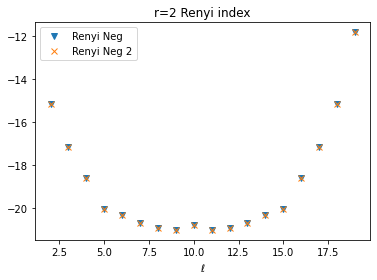

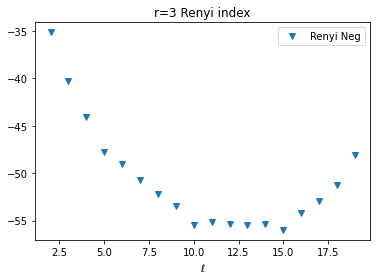

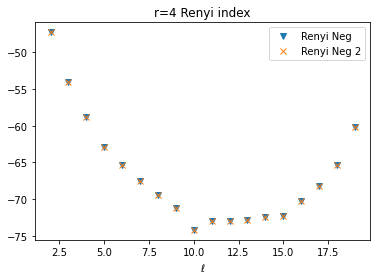

In [30]:
ent_plotter(r=2)
ent_plotter(r=3)
ent_plotter(r=4)

No handles with labels found to put in legend.


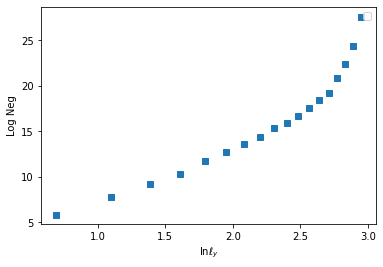

In [31]:
#plots log neg

LN_ex=np.zeros(len(Lysub_list)) # Log negativity

Gmat=np.dot(V1,np.matrix(V1).H)

for i_L in range(len(Lysub_list)):
    Lysub=Lysub_list[i_L]
    inds_A = np.arange(0,int(Lx*Lysub))
    inds_AB = np.arange(0,int(2*Lx*Lysub))
    Nsub =  int(Lx*Lysub)
    LN_ex[i_L]= exact_log_neg_calc(Nsub,Nsub,Gmat[np.ix_(inds_AB,inds_AB)])
    
plt.figure()
plt.plot(np.log(Lysub_list),LN_ex,'s')
# xplot=np.log(np.tan(pi*Lsub_list/N))
# yplot=(xplot-xplot[0])/4+ 0.47
# plt.plot(np.log(Lsub_list),yplot,label='CFT')
# plt.legend()
# plt.ylim([0,2])
plt.xlabel('$\ln \ell_y$')
plt.ylabel('Log Neg')
plt.show()